# Encoding fingerprint latent representation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/mpnn_fingerprints.ipynb)

In [1]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from pathlib import Path

from chemprop import data, featurizers, models

# Change model input here

In [3]:
chemprop_dir = Path.cwd().parent
checkpoint_path = chemprop_dir / "tests/data/example_model_v2_regression_mol.ckpt" # path to the checkpoint file.
# If the checkpoint file is generated using the training notebook,
# it will be in the `checkpoints` folder with name similar to `checkpoints/epoch=19-step=180.ckpt`.

## Load model

In [4]:
mpnn = models.MPNN.load_from_checkpoint(checkpoint_path)
mpnn.eval()
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): GraphTransform(
      (V_transform): Identity()
      (E_transform): Identity()
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metric

# Change data input here

In [5]:
test_path = '../tests/data/smis.csv'
smiles_column = 'smiles'

## Load data

In [6]:
df_test = pd.read_csv(test_path)

smis = df_test[smiles_column]

test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
test_data[:5]

[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x74122cf8cd60>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x74122cf8ce40>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x74122cf8cf20>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x74122cf8d000>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x74122cf8d0e0

# Get featurizer

In [7]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

# Get datasets

In [8]:
test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
test_loader = data.build_dataloader(test_dset, shuffle=False)

# Calculate fingerprints

`models.MPNN.encoding(inputs : BatchMolGraph, i : int)` calculate the i-th hidden representation.

`i` ia the stop index of slice of the MLP used to encode the input. That is, use all
layers in the MLP _up to_ :attr:`i` (i.e., ``MLP[:i]``). This can be any integer
value, and the behavior of this function is dependent on the underlying list
slicing behavior. For example:

* ``i=0``: use a 0-layer MLP (i.e., a no-op)
* ``i=1``: use only the first block
* ``i=-1``: use _up to_ the second-to-last block

In [9]:
with torch.no_grad():
    fingerprints = [
        mpnn.encoding(batch.bmg, batch.V_d, batch.X_d, i=0)
        for batch in test_loader
    ]
    fingerprints = torch.cat(fingerprints, 0)

fingerprints.shape

torch.Size([100, 300])

In [10]:
with torch.no_grad():
    encodings = [
        mpnn.encoding(batch.bmg, batch.V_d, batch.X_d, i=1)
        for batch in test_loader
    ]
    encodings = torch.cat(encodings, 0)

encodings.shape

torch.Size([100, 300])

# Using fingerprints

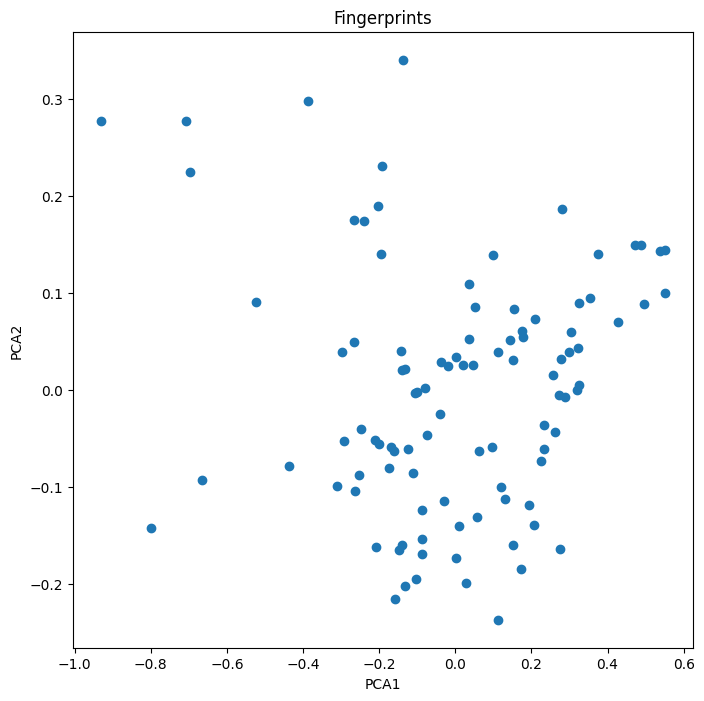

In [11]:
fingerprints = fingerprints.detach()

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(fingerprints)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Fingerprints")
ax.set_xlabel('PCA1'); ax.set_ylabel('PCA2')

ax.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.show()

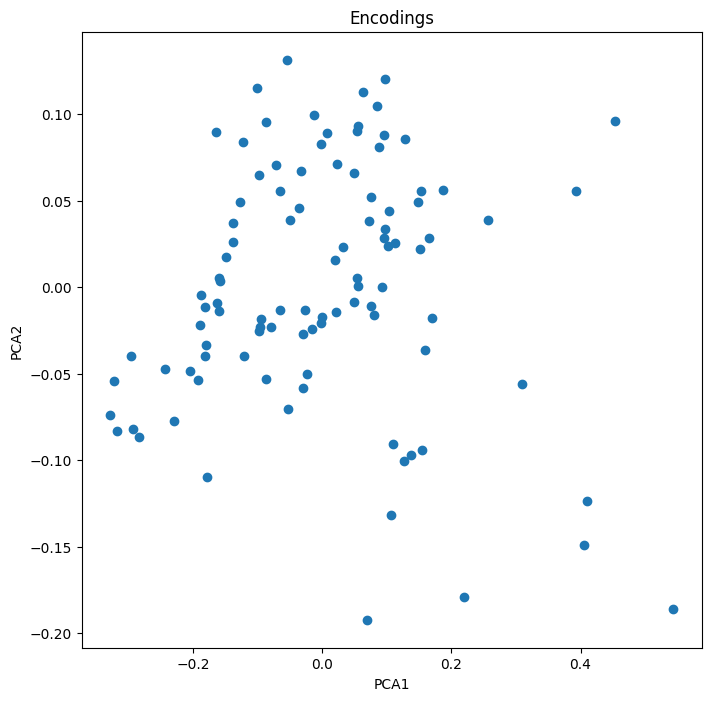

In [12]:
encodings = encodings.detach()

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(encodings)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Encodings")
ax.set_xlabel('PCA1'); ax.set_ylabel('PCA2')

ax.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.show()